In [1]:
# Imports here
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch import nn,optim
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load the data

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

batch_size = 64

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

validation_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
validation_datasets = datasets.ImageFolder(valid_dir, transform=validation_transforms)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_datasets, batch_size=batch_size, shuffle=True)

### Label mapping

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier


* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [5]:
pretrained_model = models.vgg16(pretrained=True)

params_to_update = []

for param in pretrained_model.parameters():
    param.requires_grad = False



classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088,4096)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(4096,4096)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(4096,1000)),
    ('out', nn.LogSoftmax(dim=1)),
]))

pretrained_model.classifier = classifier
pretrained_model.class_idx_mapping = train_datasets.class_to_idx
print(train_datasets.class_to_idx)
print(pretrained_model.classifier)

criterion = nn.NLLLoss()
optimizer = optim.Adam(pretrained_model.classifier.parameters(), lr=0.0001)

pretrained_model.to(device)
pretrained_model



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth

100%|██████████| 553433881/553433881 [00:05<00:00, 107436859.76it/s]


{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Epoch: 1/6..  Training Loss: 5.302..  Validation Loss: 3.899..  Validation Accuracy: 21.870

Epoch: 1/6..  Training Loss: 3.847..  Validation Loss: 2.989..  Validation Accuracy: 34.875

Epoch: 1/6..  Training Loss: 2.972..  Validation Loss: 2.032..  Validation Accuracy: 53.712

Epoch: 1/6..  Training Loss: 2.345..  Validation Loss: 1.476..  Validation Accuracy: 61.312

Epoch: 1/6..  Training Loss: 1.844..  Validation Loss: 1.237..  Validation Accuracy: 66.942

Epoch: 2/6..  Training Loss: 1.380..  Validation Loss: 0.974..  Validation Accuracy: 74.115

Epoch: 2/6..  Training Loss: 1.446..  Validation Loss: 0.915..  Validation Accuracy: 75.784

Epoch: 2/6..  Training Loss: 1.232..  Validation Loss: 0.741..  Validation Accuracy: 82.163

Epoch: 2/6..  Training Loss: 1.195..  Validation Loss: 0.658..  Validation Accuracy: 83.058

Epoch: 2/6..  Training Loss: 1.210..  Validation Loss: 0.633..  Validation Accuracy: 84.226

Epoch: 3/6..  Training Loss: 0.654..  Validation Loss: 0.569..  Valida

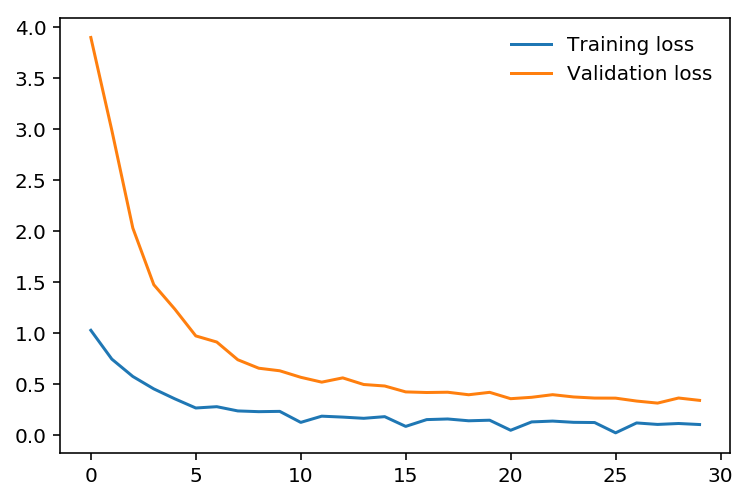

In [6]:




def validation(model, testloader, criterion, device):
    train_losses, test_losses = [], []
    test_loss = 0
    accuracy = 0
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        

    return test_loss, accuracy


def train(model, trainloader, validloader, epochs, print_every, criterion, optimizer, device='cuda'):
    steps = 0
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        running_loss = 0
        for (images, labels) in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:

                model.eval()

                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format((accuracy/len(validloader))*100))
                

                
                model.train()
                
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(validation_loss/len(validloader))
                
                running_loss = 0
                
    return train_losses, test_losses, model
                
train_losses, test_losses, model = train(model=pretrained_model, 
        trainloader=train_loader, 
        validloader=validation_loader,
        epochs=6, 
        print_every=20, 
        criterion=criterion,
        optimizer=optimizer,
        device="cuda")

print(model)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your network

In [7]:
def test_model(test_loader, model):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

print('Accuracy on Test_Data : '+str(test_model(test_loader,model))+'%')

Accuracy on Test_Data : 85.71428571428571%


## Save the checkpoint

In [8]:
model.class_idx_mapping = train_datasets.class_to_idx


In [9]:
torch.save({
            'epoch': 1,
            'classifier': model.classifier,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'criterion' : criterion.state_dict(),
            'class_idx_mapping': model.class_idx_mapping,
            'arch': "vgg16",
            'print_every': 20,
            'device': 'cuda'
            }, 'chpt1.pth')


## Loading the checkpoint

In [10]:
def load_checkpoint(model_chpt):
    chpt  = torch.load(model_chpt)
    
    
    
    
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = chpt["classifier"]
    model.load_state_dict(chpt["state_dict"])
    
    return model

loaded_model = load_checkpoint(model_chpt = 'chpt1.pth')
loaded_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification


## Image Preprocessing

Original image with size: (500, 749)


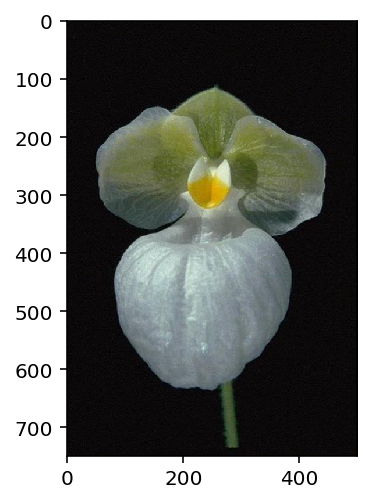

In [11]:
img = Image.open("flowers/train/2/image_05130.jpg")
print("Original image with size: {}".format(img.size))
plt.imshow(img)


In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    width,height = img.size
    print(width,height)
    n_size = 256,999999999
    img.thumbnail(n_size)
    width,height = img.size
    
    print(width,height)
    
    left = (width - 224) / 2
    right = (width + 224) / 2
    top = (height - 224) / 2
    bottom = (height + 224) / 2
    img = img.crop((left, top, right, bottom))
    
    
    
    nump_img = np.array(img)/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    nump_img = (nump_img - mean) / std
    
    nump_img = nump_img.transpose(2, 0, 1)
    
    
    return nump_img
               


500 749

256 383


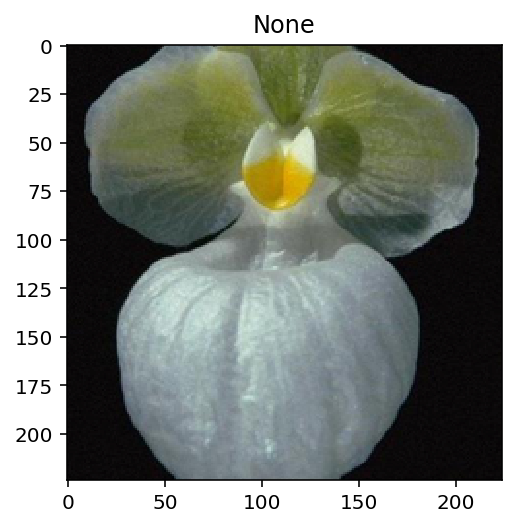

In [13]:
def imshow(image, ax, title):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

img = process_image("flowers/train/2/image_05130.jpg")
imshow(img,ax=None,title=None)

## Class Prediction

In [14]:


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    class_idx_mapping = train_datasets.class_to_idx
    idx_class_mapping = {v: k for k, v in class_idx_mapping.items()}
    
    model = load_checkpoint(model)
    
    if torch.cuda.is_available():
        model.to('cuda')
        
    np_image = process_image(image_path)
    np_image = np.resize(np_image,(1, 3, 224, 224))

    image_tensor = torch.from_numpy(np_image).type(torch.FloatTensor).to(device)
    
    model.eval()  
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    probs, indices = torch.topk(outputs, topk)
    probs = probs.exp().cpu().numpy()[0]
    indices = indices.cpu().numpy()[0]
    classes = [idx_class_mapping[index] for index in indices]
    
    return probs,classes

probs,classes = predict("flowers/train/2/image_05130.jpg","chpt1.pth")
print(probs,classes)

500 749

256 383

[  9.96052921e-01   3.11714201e-03   1.58093477e-04   1.47347368e-04

   1.12983333e-04] ['2', '20', '68', '75', '9']


## Sanity Checking

500 749

256 383

500 749

256 383


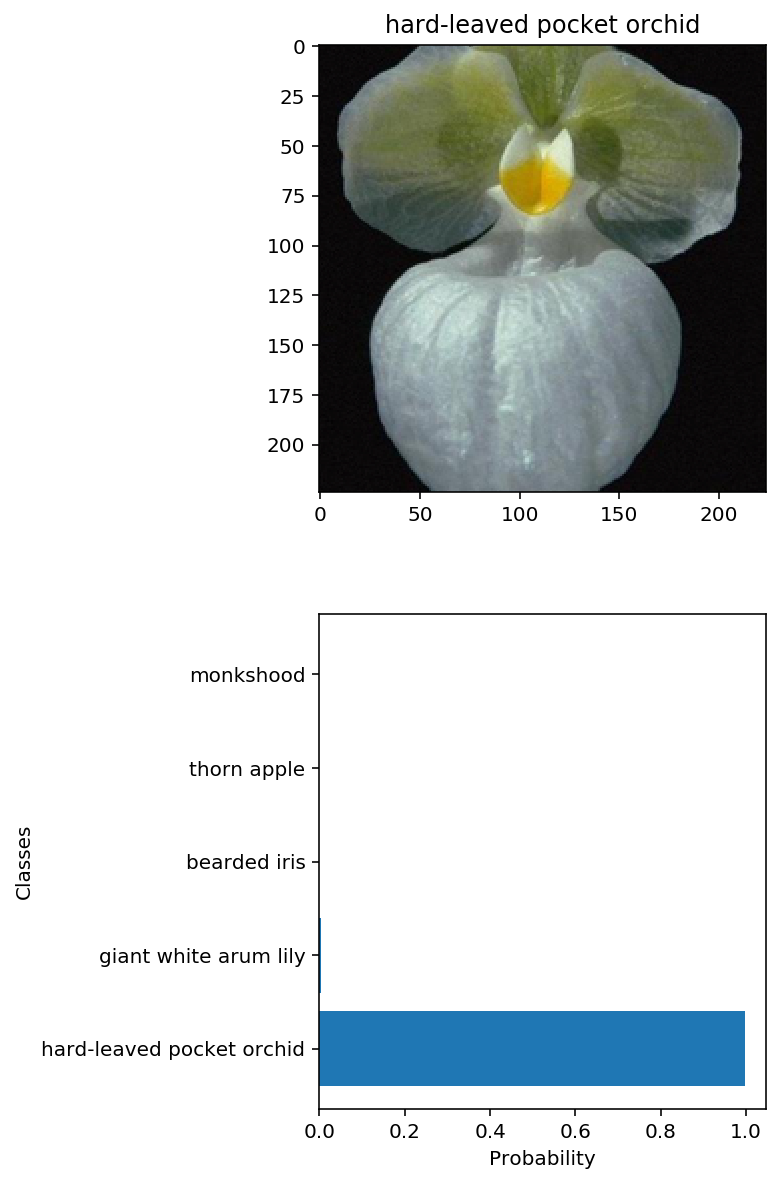

In [16]:
image = "flowers/train/2/image_05130.jpg"
probs,classes = predict("flowers/train/2/image_05130.jpg","chpt1.pth")
class_names = [cat_to_name[c] for c in classes]
class_number = image.split("/")[-2]
title = cat_to_name[str(class_number)]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4,10))

imshow(process_image(image),ax1,title)
scalars = [*range(len(probs))]
ax2.barh(scalars, probs)
plt.xlabel("Probability")
plt.ylabel("Classes")
plt.yticks(scalars, class_names)
plt.show()
